In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

In [4]:
df = pd.read_csv('goldstock.csv')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2511 entries, 0 to 2510
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  2511 non-null   int64  
 1   Date        2511 non-null   object 
 2   Close       2511 non-null   float64
 3   Volume      2511 non-null   float64
 4   Open        2511 non-null   float64
 5   High        2511 non-null   float64
 6   Low         2511 non-null   float64
dtypes: float64(5), int64(1), object(1)
memory usage: 137.4+ KB


In [10]:
df.head()

,Unnamed: 0,Date,Close,Volume,Open,High,Low
0,0,2024-01-19,2029.3,166078.0,2027.4,2041.9,2022.2
1,1,2024-01-18,2021.6,167013.0,2009.1,2025.6,2007.7
2,2,2024-01-17,2006.5,245194.0,2031.7,2036.1,2004.6
3,3,2024-01-16,2030.2,277995.0,2053.4,2062.8,2027.6
4,4,2024-01-12,2051.6,250946.0,2033.2,2067.3,2033.1


In [12]:
df.shape

(2511, 7)

In [14]:
df.isnull().sum()

Unnamed: 0    0
Date          0
Close         0
Volume        0
Open          0
High          0
Low           0
dtype: int64

In [16]:
df.describe()

,Unnamed: 0,Close,Volume,Open,High,Low
count,2511.000000,2511.000000,2511.000000,2511.000000,2511.000000,2511.000000
mean,1260.792911,1498.726085,185970.770609,1498.725528,1508.451454,1488.869932
std,729.262879,298.824811,97600.769382,299.118187,301.262244,296.417703
min,0.000000,1049.600000,1.000000,1051.500000,1062.700000,1045.400000
25%,630.500000,1249.850000,126693.500000,1249.500000,1257.300000,1242.350000
50%,1259.000000,1332.800000,175421.000000,1334.000000,1342.400000,1326.600000
75%,1888.500000,1805.850000,234832.000000,1805.600000,1815.450000,1793.050000
max,2532.000000,2093.100000,787217.000000,2094.400000,2098.200000,2074.600000


In [18]:
# Data Preprocessing
# Drop unnecessary column
df = df.drop(columns=['Unnamed: 0'], errors='ignore')

In [20]:
# Parse dates
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df = df.dropna(subset=['Date'])

In [22]:
# Clean numerical columns
numeric_columns = ['Open', 'High', 'Low', 'Close', 'Volume']
for col in numeric_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

In [24]:
# Drop rows with missing values
df = df.dropna()

In [26]:
# Sort by date for chronological order
df = df.sort_values('Date')

In [28]:
# Feature Engineering
df['MA5'] = df['Close'].rolling(window=5).mean()
df['MA10'] = df['Close'].rolling(window=10).mean()
df['Price_Diff'] = df['Close'].diff()
df['High_Low_Spread'] = df['High'] - df['Low']
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Volatility'] = df['Close'].rolling(window=20).std()  # 20-day rolling std for volatility

In [30]:
# Drop rows with NaN from rolling calculations
df = df.dropna()

In [32]:
# Exploratory Data Analysis
# 1. Data Summary
print("Dataset Info:")
print(df.info())
print("\nDescriptive Statistics:")
print(df[numeric_columns + ['MA5', 'MA10', 'Price_Diff', 'High_Low_Spread', 'Volatility']].describe())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
Index: 2492 entries, 2491 to 0
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Date             2492 non-null   datetime64[ns]
 1   Close            2492 non-null   float64       
 2   Volume           2492 non-null   float64       
 3   Open             2492 non-null   float64       
 4   High             2492 non-null   float64       
 5   Low              2492 non-null   float64       
 6   MA5              2492 non-null   float64       
 7   MA10             2492 non-null   float64       
 8   Price_Diff       2492 non-null   float64       
 9   High_Low_Spread  2492 non-null   float64       
 10  Year             2492 non-null   int32         
 11  Month            2492 non-null   int32         
 12  Volatility       2492 non-null   float64       
dtypes: datetime64[ns](1), float64(10), int32(2)
memory usage: 253.1 KB
None

Descriptive

In [34]:
# 2. Missing Values
print("\nMissing Values:")
print(df.isnull().sum())


Missing Values:
Date               0
Close              0
Volume             0
Open               0
High               0
Low                0
MA5                0
MA10               0
Price_Diff         0
High_Low_Spread    0
Year               0
Month              0
Volatility         0
dtype: int64


In [36]:
# 3. Correlation Analysis
features = ['Open', 'High', 'Low', 'Volume', 'MA5', 'MA10', 'Price_Diff', 'High_Low_Spread', 'Volatility', 'Close']
corr_matrix = df[features].corr()

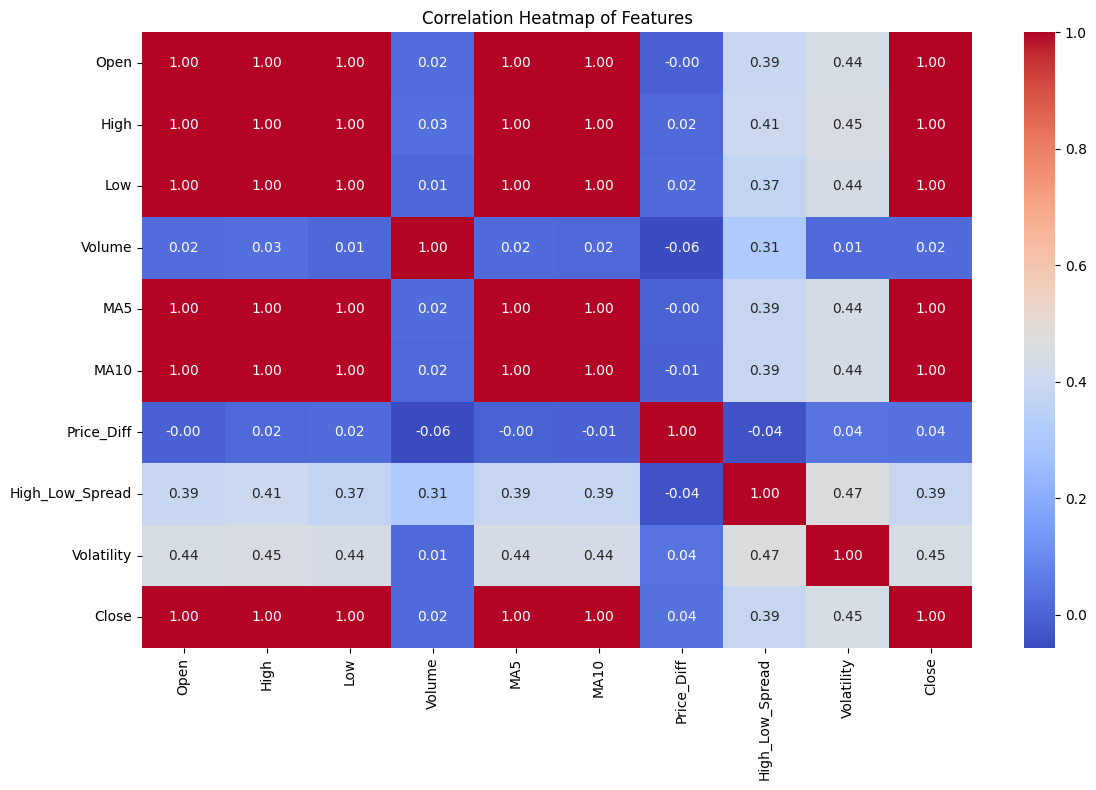

In [44]:
# Plot correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Features')
plt.tight_layout()

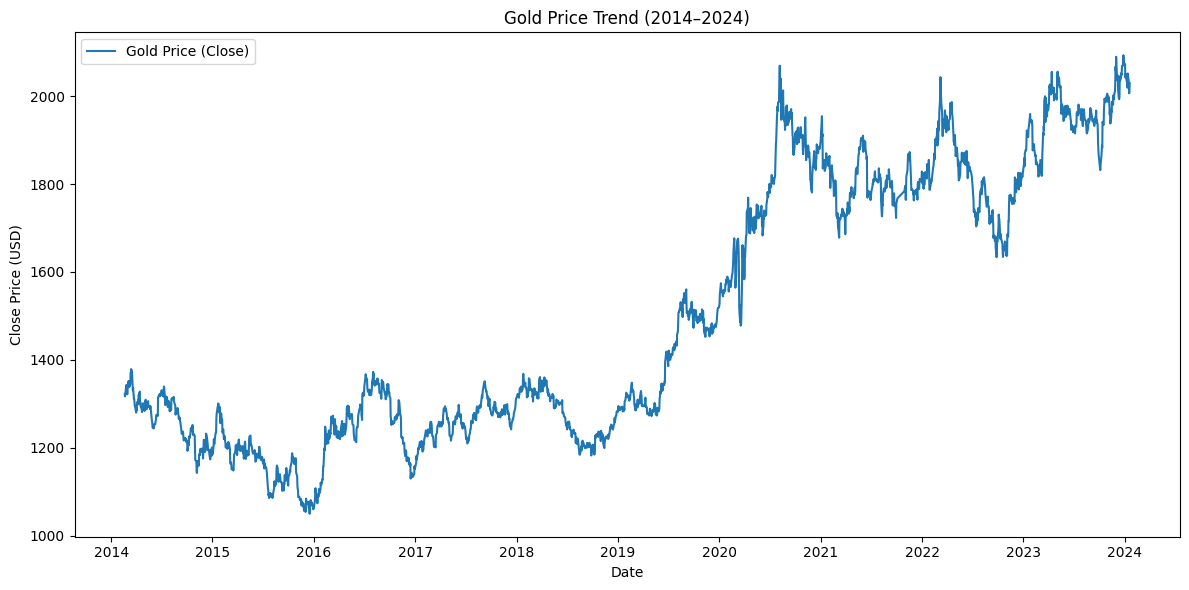

In [46]:
# 4. Gold Price Trend
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Close'], label='Gold Price (Close)')
plt.title('Gold Price Trend (2014–2024)')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.legend()
plt.tight_layout()

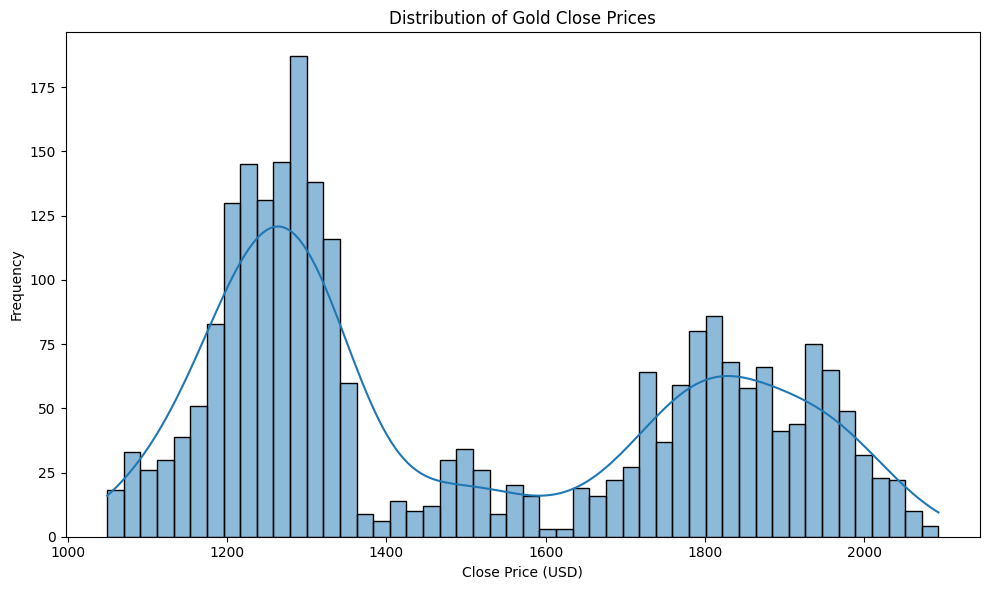

In [48]:
# 5. Distribution of Close Price
plt.figure(figsize=(10, 6))
sns.histplot(df['Close'], bins=50, kde=True)
plt.title('Distribution of Gold Close Prices')
plt.xlabel('Close Price (USD)')
plt.ylabel('Frequency')
plt.tight_layout()

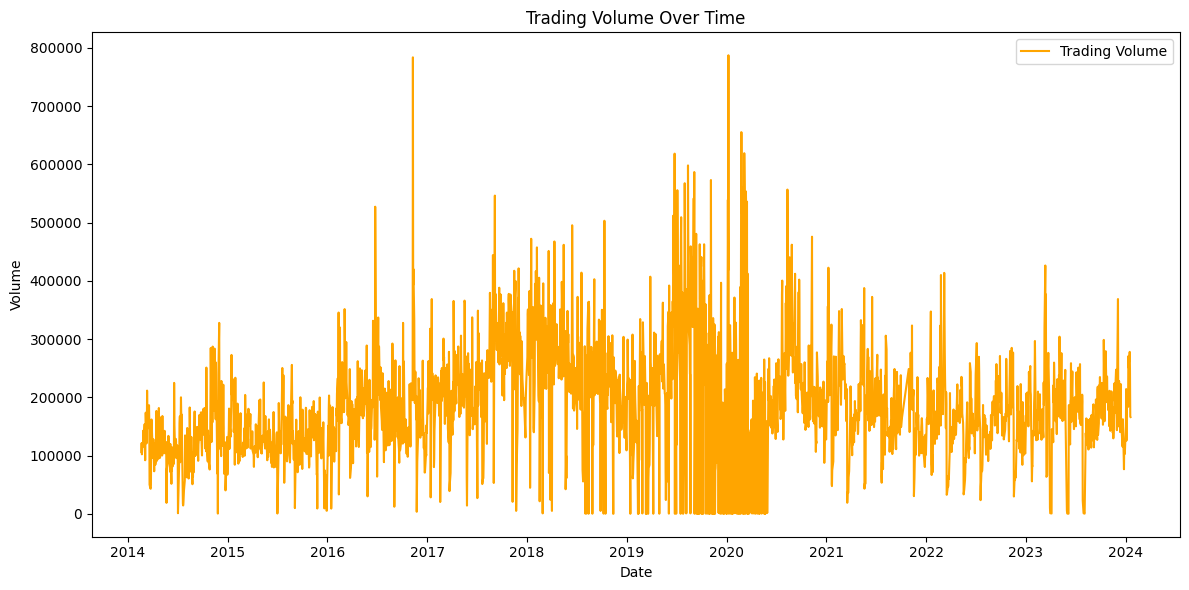

In [50]:
# 6. Volume Trend
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Volume'], label='Trading Volume', color='orange')
plt.title('Trading Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.tight_layout()

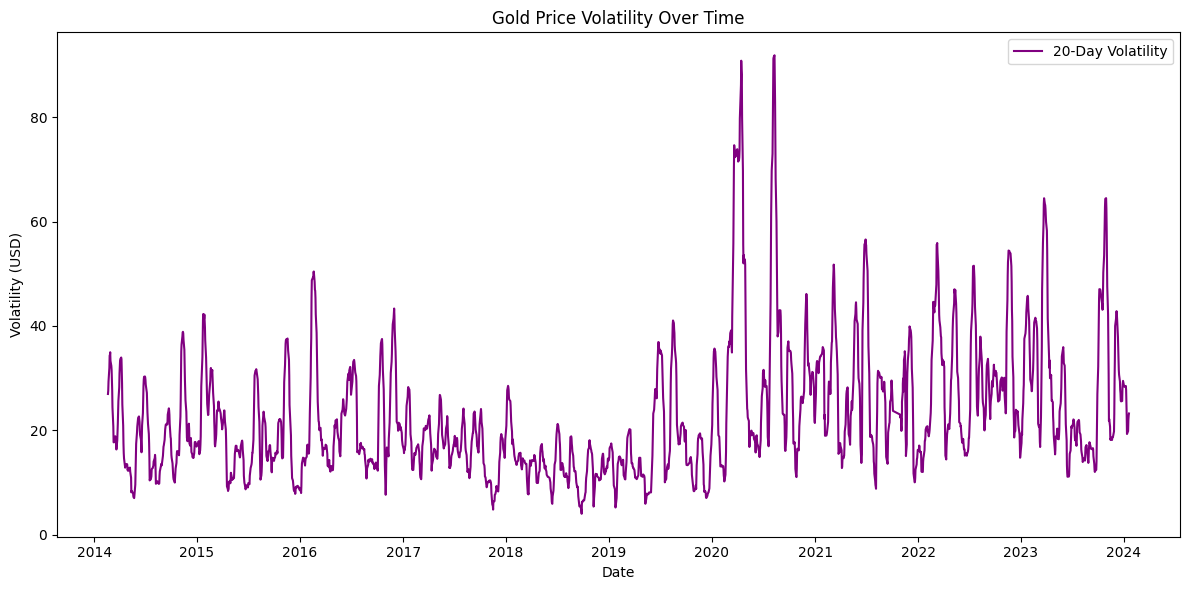

In [52]:
# 7. Volatility Trend
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Volatility'], label='20-Day Volatility', color='purple')
plt.title('Gold Price Volatility Over Time')
plt.xlabel('Date')
plt.ylabel('Volatility (USD)')
plt.legend()
plt.tight_layout()

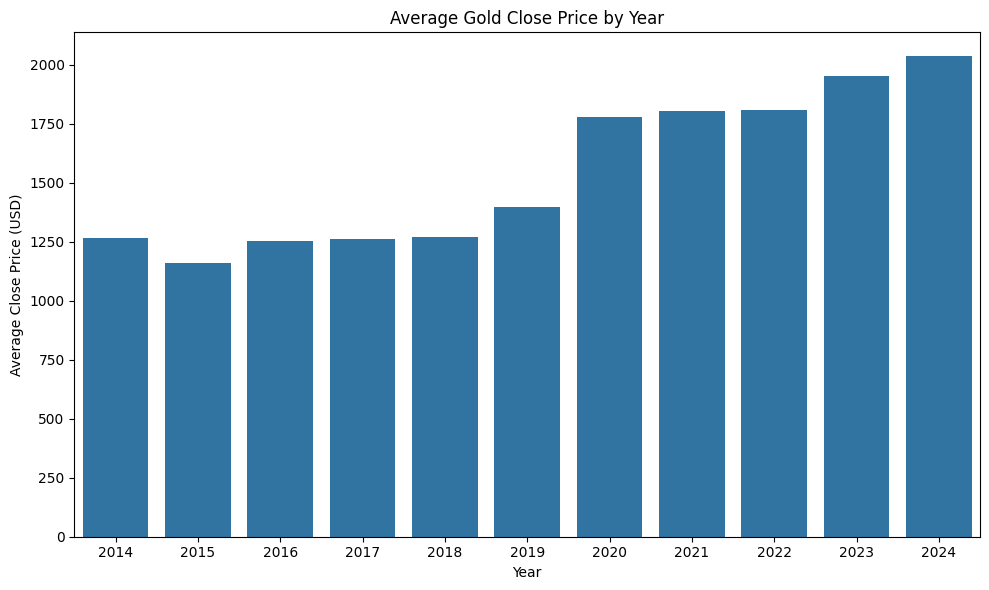

In [54]:
# 8. Yearly Average Close Price
yearly_avg = df.groupby('Year')['Close'].mean().reset_index()
plt.figure(figsize=(10, 6))
sns.barplot(x='Year', y='Close', data=yearly_avg)
plt.title('Average Gold Close Price by Year')
plt.xlabel('Year')
plt.ylabel('Average Close Price (USD)')
plt.tight_layout()

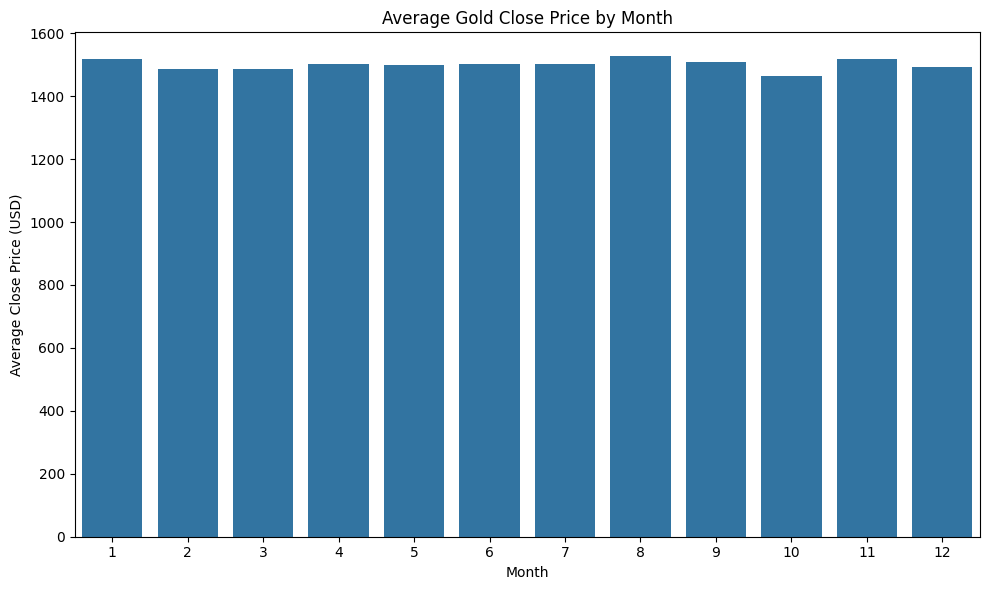

In [56]:
# 9. Monthly Average Close Price
monthly_avg = df.groupby('Month')['Close'].mean().reset_index()
plt.figure(figsize=(10, 6))
sns.barplot(x='Month', y='Close', data=monthly_avg)
plt.title('Average Gold Close Price by Month')
plt.xlabel('Month')
plt.ylabel('Average Close Price (USD)')
plt.tight_layout()

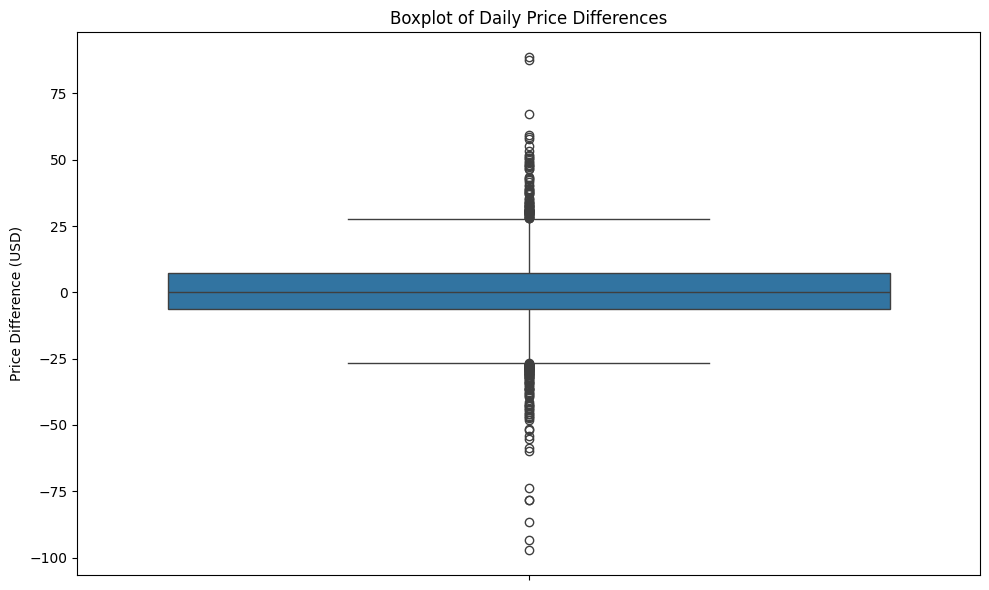

In [58]:
# 10. Outlier Detection (Boxplot for Price_Diff)
plt.figure(figsize=(10, 6))
sns.boxplot(y=df['Price_Diff'])
plt.title('Boxplot of Daily Price Differences')
plt.ylabel('Price Difference (USD)')
plt.tight_layout()

In [60]:
# Feature Selection and Normalization
selected_features = ['Open', 'High', 'Low', 'Volume', 'MA5', 'MA10', 'Price_Diff', 'High_Low_Spread', 'Volatility']
target = 'Close'

In [62]:
X = df[selected_features]
y = df[target]

In [64]:
# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=selected_features, index=X.index)

In [66]:
# Split the data (80% train, 20% test, chronological)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, shuffle=False)

In [68]:
# Train Random Forest Model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [70]:
# Make Predictions
y_pred = model.predict(X_test)

In [72]:
# Evaluate Model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [74]:
# Cross-Validation
cv_scores = cross_val_score(model, X_scaled, y, cv=5, scoring='r2')
cv_mean = cv_scores.mean()
cv_std = cv_scores.std()

In [76]:
# Print evaluation metrics
print(f"\nModel Evaluation:")
print(f"Mean Squared Error: {mse:.2f}")
print(f"R² Score: {r2:.2f}")
print(f"Cross-Validation R²: {cv_mean:.2f} ± {cv_std:.2f}")


Model Evaluation:
Mean Squared Error: 88.93
R² Score: 0.99
Cross-Validation R²: 0.97 ± 0.03


In [78]:
# Feature Importance
feature_importance = pd.DataFrame({
    'Feature': selected_features,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

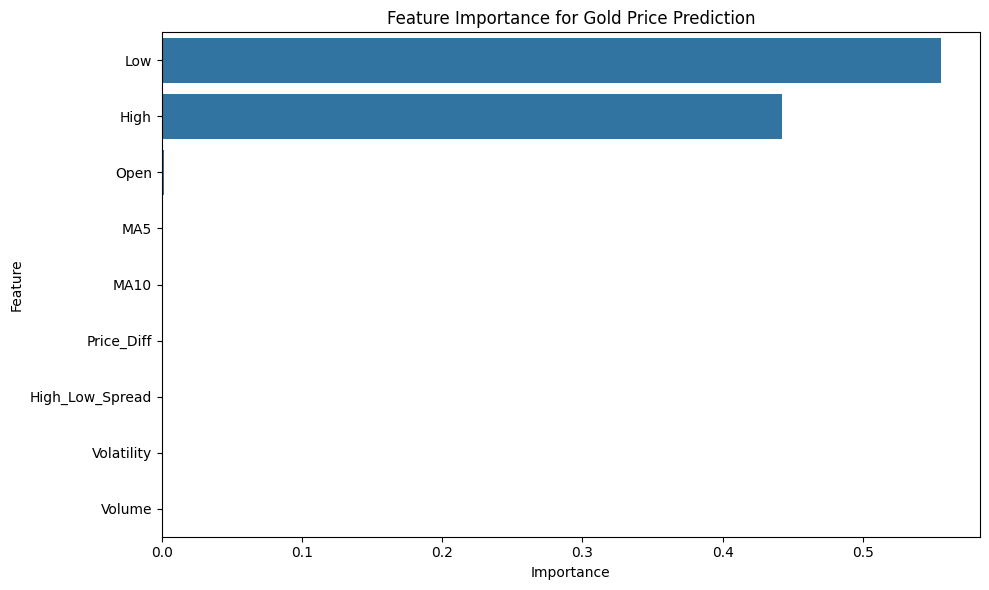

In [82]:
# Plot Feature Importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance for Gold Price Prediction')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()

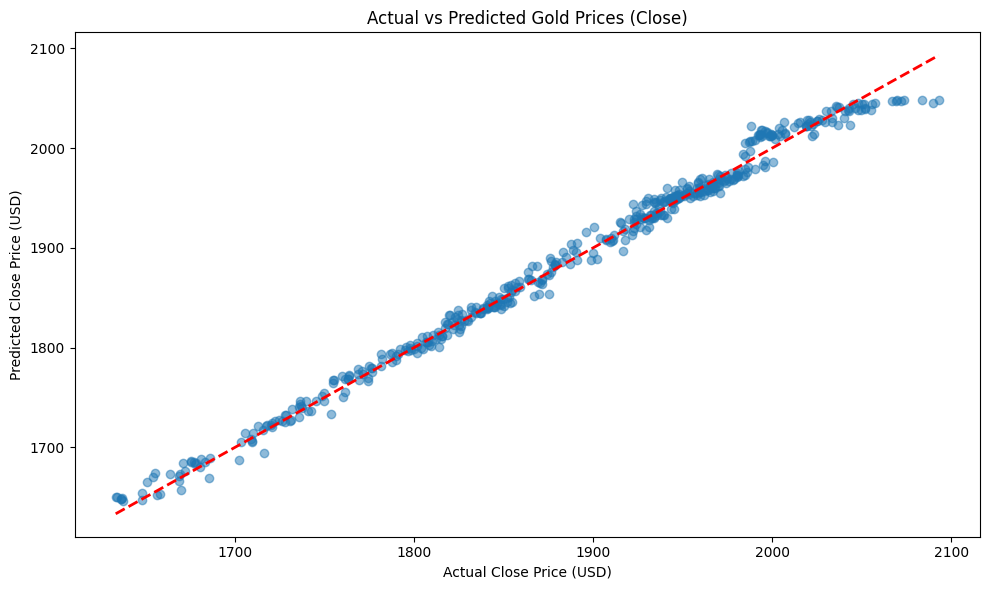

In [84]:
# Plot Actual vs Predicted Prices
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title('Actual vs Predicted Gold Prices (Close)')
plt.xlabel('Actual Close Price (USD)')
plt.ylabel('Predicted Close Price (USD)')
plt.tight_layout()

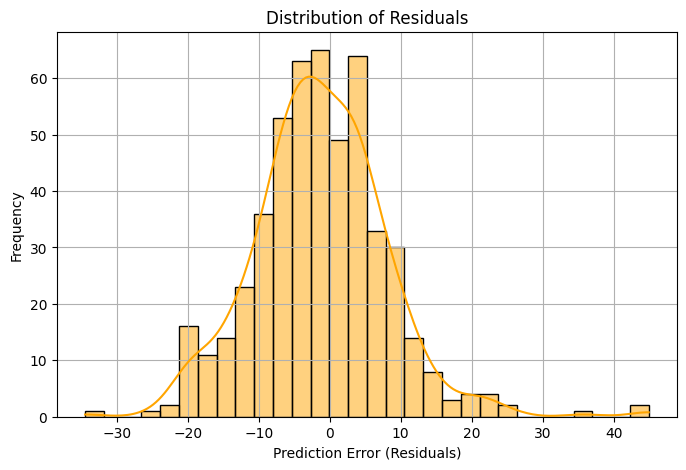

In [88]:
residuals = y_test - y_pred

plt.figure(figsize=(8, 5))
sns.histplot(residuals, kde=True, color='orange', bins=30)
plt.title("Distribution of Residuals")
plt.xlabel("Prediction Error (Residuals)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

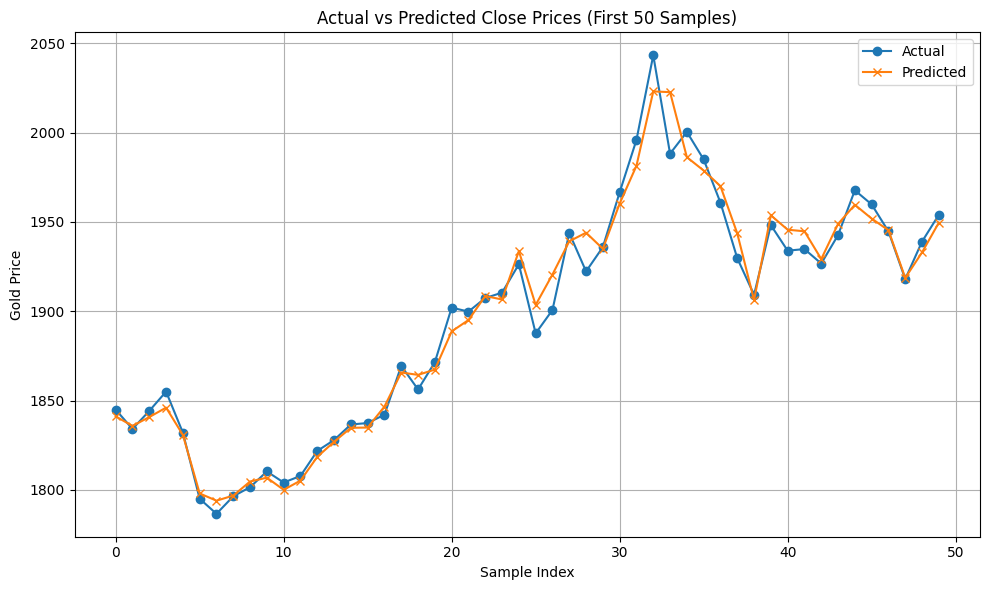

In [90]:
plt.figure(figsize=(10, 6))
plt.plot(y_test.values[:50], label='Actual', marker='o')
plt.plot(y_pred[:50], label='Predicted', marker='x')
plt.title('Actual vs Predicted Close Prices (First 50 Samples)')
plt.xlabel('Sample Index')
plt.ylabel('Gold Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

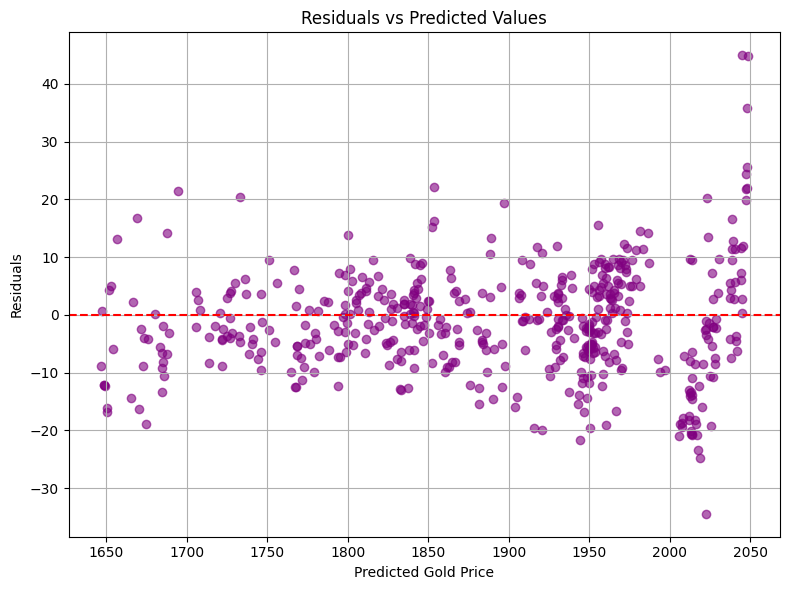

In [92]:
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, color='purple', alpha=0.6)
plt.axhline(0, linestyle='--', color='red')
plt.xlabel("Predicted Gold Price")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Values")
plt.grid(True)
plt.tight_layout()
plt.show()